In [ ]:
import pandas as pd

# Paths to your uploaded files
expression_path = "expression"
mutations_path = "mutations"
zscore_path = "zscore"
clinical_path = "phenotype"

# Load all files
expression_df = pd.read_csv(expression_path, sep='\t', index_col=0) #20,530 genes x 550 samples
#rows = genes(PDCD1, CD274,etc), columns = samples(TCGA-CH-5744-01), values = gene expression levels, measured via RNA-seq transformed as log2(RSEM+1)
# tells us how active each gene is in each patients tumor, ie. high PDCD1 expression = more immune inhibition
# Use case-pull expression of immune related or cancer relevant genes
# use z score normalization to compare expression levels across patients
# input those values into our ML model as numeric features to train 
mutations_df = pd.read_csv(mutations_path, sep='\t', index_col=0) #31,104 mutation rows across 550 patients
#rows=one mutation in one sample, columns=chr,start,end(where in genome mutation occured)
#reference,alt=original vs mutated DNA base
#gene=which gene is affected
#effect=type of mutation(missense_mutation,nonsense,etc)
#sample=the patient/sample ID
# THIS is the mutation landscape of each tumor 
# used to calculate TMB(tumor mutational burden): total # of mutations in each tumor
# USE CASE: calculate TMB, normalize TMB using zscore, use as numeric input feature in model
zscore_df = pd.read_csv(zscore_path, sep='\t', index_col=0) #1,387 immune pathway scores x 488 samples
#rows:pathway or signature(G2_Phase, IFN_gamma), columns: samples(TCGA-YL-A8SP-01), values:zscore of activity level of that pathway for each sample
#prepcomputed using GSVA(Gene set variation analysis)
#each row represents a coordinated gene program, provides a higher level summary of immune activity
#USE CASE: select immune-related GSVA scores(predictive of ICI response)
#normalize if needed(already z scored), feed as numeric input to ML model

#OUTPUT TARGET
clinical_df = pd.read_csv(clinical_path, sep='\t', index_col=0) #104 clinical variables x 566 patients
#row:each is a patient/sample, column: clinical and demographic variables such as below
# age_at_initial_pathologic_diagnosis, gleason_score, primary_therapy_outcome_success(OUR TARGET), tumor_stage, residual_tumor, etc.
#tells us what ACTUALLY happened to patient(treatment, worked or not, clinical indicators(gleason, etc.))
#USE CASE: use PRIMARY_THERAPY_OUTCOME_SUCCESS to define response(1=responder,0=nonresponder)
#use predictors like gleason, age, PSA level, etc, JOIN ON SAMPLEID WITH OTHER DATASETS

# Check shapes and preview
print(expression_df.shape)
print(mutations_df.shape)
print(zscore_df.shape)
print(clinical_df.shape)

expression_df.head(2), mutations_df.head(2), zscore_df.head(2), clinical_df.head(2)

(20530, 550)
(31104, 11)
(1387, 488)
(566, 104)


(           TCGA-XJ-A83F-01  TCGA-G9-6348-01  TCGA-CH-5766-01  TCGA-EJ-A65G-01  \
 sample                                                                          
 ARHGEF10L           9.3554           8.8729           8.5581           9.2085   
 HIF3A               5.1517           5.9049           4.9716           6.7795   
 
            TCGA-G9-6354-01  TCGA-EJ-5527-01  TCGA-HC-8213-01  TCGA-Y6-A9XI-01  \
 sample                                                                          
 ARHGEF10L           9.0514           8.7699           8.5544           9.0878   
 HIF3A               5.3511           5.5978           3.7947           4.7539   
 
            TCGA-EJ-7125-11  TCGA-CH-5744-01  ...  TCGA-HC-A6AP-01  \
 sample                                       ...                    
 ARHGEF10L           8.4893           9.4441  ...           9.9893   
 HIF3A               6.9225           4.8565  ...           7.4100   
 
            TCGA-EJ-7317-01  TCGA-YL-A8S9-01  TCGA-KK-A8IA

Feature extraction + label definition
1. Extract 4 key gene expressions: PDCD1, CD274, TGFB1, CCND1
2. Calculate TMB: count mutations per sample from mutations_df
3. Select immune-related GSVA z-scores
4. Extract target label from clinical outcome column

Built a feature matrix (485, 7), 485 patient samples with 7 input columns(4 expression features(PDCD1, CD274, TGFB1, CCND1), 1 mutation feature(TMB), 1 immune pathway score(tgf_beta_signaling_pathway from GSVA zscores), 1 label(response, target variable)), each row is a sample(patient or tumor) each column is a feature for the sample

In [12]:
from sklearn.preprocessing import StandardScaler

# --- 1. Expression Features ---
genes_of_interest = ['PDCD1', 'CD274', 'TGFB1', 'CCND1'] #selects the ONLY 4 immune related genes out of 20,530
expr_selected = expression_df.loc[expression_df.index.intersection(genes_of_interest)].T #transpose the dataframe so rows=samples,columns=selected genes
expr_selected.columns = ['PDCD1_expr', 'CD274_expr', 'TGFB1_expr', 'CCND1_expr'] #renames columns clearer
expr_selected = pd.DataFrame(StandardScaler().fit_transform(expr_selected), #standardizes all values to z scores
                             columns=expr_selected.columns,
                             index=expr_selected.index)

# --- 2. TMB Feature ---
# Count unique mutations per sample
tmb_series = mutations_df.groupby(mutations_df.index).size() ## of mutations/patient = TMB
tmb_df = tmb_series.to_frame(name='TMB') #converts series to data frame
tmb_df['TMB'] = StandardScaler().fit_transform(tmb_df[['TMB']]) #standardizes TMB scores using Zscore

# --- 3. GSVA Immune Pathways ---
# Select immune-related pathways (based on bladder cancer paper)
immune_signatures = ['IFN', 'CD8', 'Stroma', 'TGF', 'Antigen', 'HLA', 'Macrophage']

# Try fuzzy match if needed
#problem: GSVA row names in dataset might not match immune_signatures
available_paths = zscore_df.index.str.lower()
gsva_selected = zscore_df.loc[
    [i for i in zscore_df.index if any(x.lower() in i.lower() for x in immune_signatures)]
].T
gsva_selected = pd.DataFrame(StandardScaler().fit_transform(gsva_selected),
                             columns=gsva_selected.columns,
                             index=gsva_selected.index)

# --- 4. Clinical Label ---
# Define response: "Complete Remission/Response" = 1, else = 0, this is our Y, target variable
label_col = 'primary_therapy_outcome_success'
clinical_df[label_col] = clinical_df[label_col].fillna("Missing")
clinical_df['response'] = clinical_df[label_col].apply(lambda x: 1 if 'Complete' in str(x) else 0)
labels = clinical_df[['response']]

# --- Combine all features ---
# Join everything by sample ID
features = expr_selected.join([tmb_df, gsva_selected], how='inner')
features = features.join(labels, how='inner')

# Show final dataset shape and preview
features.shape, features.head()

((485, 36),
                  PDCD1_expr  CD274_expr  TGFB1_expr  CCND1_expr       TMB  \
 TCGA-XJ-A83F-01   -0.091293   -2.230654   -1.538999   -1.255588 -0.060230   
 TCGA-G9-6348-01    0.649282   -0.284371    0.751237    0.132216 -0.027593   
 TCGA-CH-5766-01   -0.851541    0.564695    0.799928   -1.020530 -0.050905   
 TCGA-EJ-A65G-01   -2.015140   -0.923169   -1.566011   -0.156492 -0.095198   
 TCGA-G9-6354-01   -1.410114   -1.859787    0.249258   -1.491273 -0.064893   
 
                  the_information_processing_pathway_at_the_ifn_beta_enhancer  \
 TCGA-XJ-A83F-01                                           0.280474             
 TCGA-G9-6348-01                                          -0.015585             
 TCGA-CH-5766-01                                           0.581586             
 TCGA-EJ-A65G-01                                          -0.409152             
 TCGA-G9-6354-01                                          -0.557182             
 
                  Downregulati

Split data into Train/Test sets, stratification ensures both classes (0,1) are proportionally represented in both sets so no bias

In [13]:
from sklearn.model_selection import train_test_split

# Separate X (features) and y (label)
X = features.drop(columns=['response'])
y = features['response']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42  # for reproducibility
)

# Check class balance
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(response
 1    0.680412
 0    0.319588
 Name: proportion, dtype: float64,
 response
 1    0.680412
 0    0.319588
 Name: proportion, dtype: float64)

68% responders, 32% non responders

Train a logistic regresion baseline, penalty L2 prevents overfitting, score with roc_auc, 5 fold stratified cross validation for g=better generalization estimate

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Instantiate model
#creates/defines the model
lr_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Fit model on training data
lr_model.fit(X_train, y_train)

# Predict probabilities for test set
y_probs = lr_model.predict_proba(X_test)[:, 1]  # probability of class 1
y_pred = lr_model.predict(X_test)               # hard prediction (0,1) using 0.5 as the default threshold

# Evaluate with AUC
auc = roc_auc_score(y_test, y_probs)

# Show metrics
print(f"AUC: {auc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred)) #gives precision(% correct), recall(how many positives found), f1score(harmonic mean of precision&recall)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred)) #shows 2x2 table of actual vs predicted outcomes

AUC: 0.567

Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.23      0.29        31
           1       0.70      0.85      0.77        66

    accuracy                           0.65        97
   macro avg       0.56      0.54      0.53        97
weighted avg       0.61      0.65      0.62        97


Confusion Matrix:
 [[ 7 24]
 [10 56]]


pretty bad AUC, right above random guessing 0.5, classification report shows model is biased towards predicting responders(1), correctly found 85% of actual responders(good recall), missed 77% of non responders(only found 7/31 of them), most likely caused by 68% responders in train set

confustion matrix(negative=non, positive=responder), 7 true negative, 24 false negative, 56 true positive, 10 false positive

GREAT at identifying responders but bad at identifying non responders

NOW WERE DOING RANDOM FOREST, better modeling of complex relationships, built in feature importance ranking, resilience to overfitting, n_estimators=100=# decision trees, max_depth=none lets trees fully grow(prevent underfitting), n_jobs=-1 use all CPU cores to speed up, class_weight='balanced' counteracts responder imbalance 68/32 split

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Instantiate model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Train
rf_model.fit(X_train, y_train)

# Predict
rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_preds = rf_model.predict(X_test)

# Evaluate
rf_auc = roc_auc_score(y_test, rf_probs)
print(f"AUC: {rf_auc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, rf_preds))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, rf_preds))

AUC: 0.581

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.10      0.15        31
           1       0.69      0.92      0.79        66

    accuracy                           0.66        97
   macro avg       0.53      0.51      0.47        97
weighted avg       0.59      0.66      0.58        97


Confusion Matrix:
 [[ 3 28]
 [ 5 61]]


still biased towards responders, but slightly better

FEATURE IMPORTANCE ANALYSIS(GINI IMPURITY): determines which features are important and which are redundant/noisy

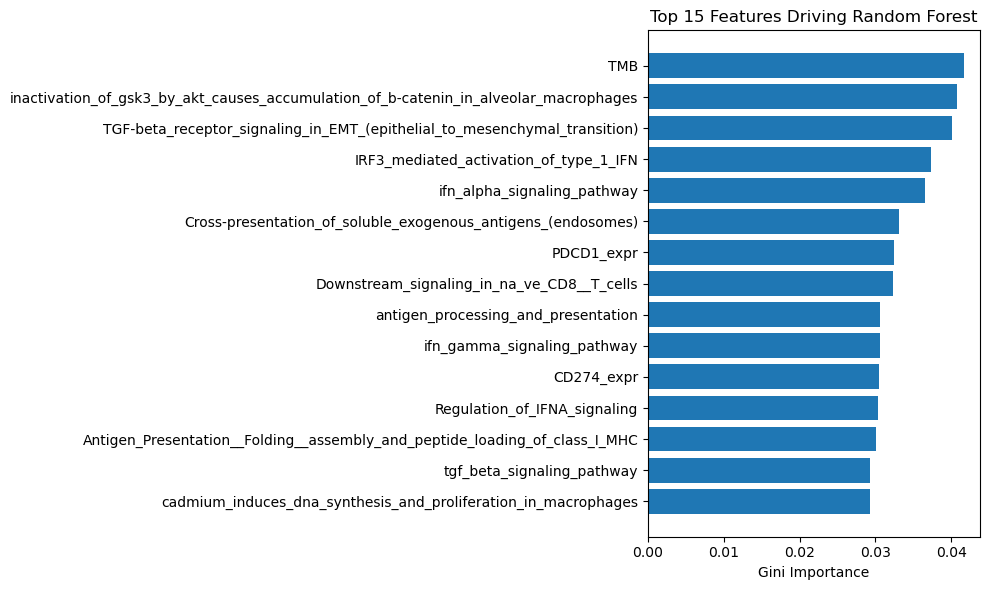

,feature,importance
4,TMB,0.041707
17,inactivation_of_gsk3_by_akt_causes_accumulatio...,0.040751
8,TGF-beta_receptor_signaling_in_EMT_(epithelial...,0.040065
11,IRF3_mediated_activation_of_type_1_IFN,0.037337
18,ifn_alpha_signaling_pathway,0.036495
22,Cross-presentation_of_soluble_exogenous_antige...,0.033144
0,PDCD1_expr,0.032379
34,Downstream_signaling_in_na_ve_CD8__T_cells,0.032367
13,antigen_processing_and_presentation,0.030635
27,ifn_gamma_signaling_pathway,0.030600


In [17]:
import matplotlib.pyplot as plt

# Extract and sort feature importances
importances = rf_model.feature_importances_
feature_names = X_train.columns

feature_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
plt.barh(feature_df['feature'][:15][::-1], feature_df['importance'][:15][::-1])
plt.xlabel("Gini Importance")
plt.title("Top 15 Features Driving Random Forest")
plt.tight_layout()
plt.show()

# Show table
feature_df.head(15)

NOW, want to clean/refine GSVA Feature selection, get ONLY TOP IMMUNE RELATED GSVA PATHWAYS, manually curate a list of immune-related GSVA pathways, rows in zscore_df that biologically make sense as predictors of immunotherapy response, are not redundant and are specific, ASK PROFESSOR WANG ABOUT THIS

Here’s a starting set you can likely trust:

Pathway Type	What to Look For in zscore_df.index
IFN-γ               ifn_gamma, interferon_gamma, IRF
CD8 T-effector	    CD8, cytotoxic, effector
TGF-β	            tgf, stroma, emt
APM	                antigen_presentation, mhc, cross_presentation
M1 macrophages	    macrophage_m1, m1_activation
PD-1 modules	    PDCD1, PD-1, checkpoint, immune_exhaustion
Inflammation	    inflammatory_response, IL-6, TNF, cytokine_response

In [21]:
# Show all GSVA features currently in the model
current_gsva_features = [f for f in X_train.columns if f in zscore_df.index]
print("GSVA features currently used in model:")
current_gsva_features

GSVA features currently used in model:


['the_information_processing_pathway_at_the_ifn_beta_enhancer',
 'Downregulation_of_TGF-beta_receptor_signaling',
 'TGF-beta_receptor_signaling_activates_SMADs',
 'TGF-beta_receptor_signaling_in_EMT_(epithelial_to_mesenchymal_transition)',
 'RIG-I/MDA5_mediated_induction_of_IFN-alpha/beta_pathways',
 'DAI_mediated_induction_of_type_I_IFNs',
 'IRF3_mediated_activation_of_type_1_IFN',
 'IFN-gamma_pathway',
 'antigen_processing_and_presentation',
 'STING_mediated_induction_of_type_1_IFN',
 'Inhibition_of_IFN-beta',
 'cadmium_induces_dna_synthesis_and_proliferation_in_macrophages',
 'inactivation_of_gsk3_by_akt_causes_accumulation_of_b-catenin_in_alveolar_macrophages',
 'ifn_alpha_signaling_pathway',
 'Cross-presentation_of_particulate_exogenous_antigens_(phagosomes)',
 'Antigen_processing__Ubiquitination___Proteasome_degradation',
 'Antigen_Presentation__Folding__assembly_and_peptide_loading_of_class_I_MHC',
 'Cross-presentation_of_soluble_exogenous_antigens_(endosomes)',
 'MHC_class_II_a

In [24]:
print("All available GSVA pathway names:")
zscore_df.index.to_list()

All available GSVA pathway names:


['G2_Phase',
 'Processive_synthesis_on_the_lagging_strand',
 'Removal_of_the_Flap_Intermediate',
 'Ubiquitin-dependent_degradation_of_Cyclin_D1',
 'Establishment_of_Sister_Chromatid_Cohesion',
 'Association_of_licensing_factors_with_the_pre-replicative_complex',
 'Removal_of_licensing_factors_from_origins',
 'extrinsic_prothrombin_activation_pathway',
 'IL23-mediated_signaling_events',
 'il-7_signal_transduction',
 'growth_hormone_signaling_pathway',
 'CDO_in_myogenesis',
 'G_alpha_(s)_signalling_events',
 'Opsins',
 'Free_fatty_acid_receptors',
 'Adenosine_P1_receptors',
 'Lysosphingolipid_and_LPA_receptors',
 'Glucagon-type_ligand_receptors',
 'Class_C/3_(Metabotropic_glutamate/pheromone_receptors)',
 'Class_B/2_(Secretin_family_receptors)',
 'Calcitonin-like_ligand_receptors',
 'chromatin_remodeling_by_hswi/snf_atp-dependent_complexes',
 'how_does_salmonella_hijack_a_cell',
 'sprouty_regulation_of_tyrosine_kinase_signals',
 'erythropoietin_mediated_neuroprotection_through_nf-kb',
 '

In [ ]:
handpicked = [
    'ifn_gamma_signaling_pathway',
    'cd8_t_effector_cell_response',
    'antigen_processing_and_presentation',
    'tgf_beta_signaling_pathway',
    'stroma_related_pathway',
    'pdcd1_pathway',
    'm1_macrophage_activation'
]

gsva_cleaned = zscore_df.loc[zscore_df.index.intersection(handpicked)].T

recommend use one dataset at once, mutation and expression, preprocess mutation, ATCG nucleosides any sequence, a gene is 10,000 combo of atcg, mutations are one point in the 10,000 are changed to anither example, T to A, or a shorter piece deleted or a short piece inserted, or a nucleoside is changes, pateint id and gene name in mutation shows us the change, all 0 on gene is normal, 1 is the change, features is different genes, 20,000 genes more, each pateint has 20,000 genes, each gene has an expression value, each gene is a feature, dont need to use 20,000, select most important , try mutation first than try gene expression

find the types of models used and data used in the paper

models used in the paper, 
logistic regression(L1)(baseline model, drops uninformative features, interpret which features are positively vs negatively associated with response) 

stochastic gradient descent(SGD)(linear model, flexibility in large,sparse datasets, used for robustness checks)

random forest(main model)(best performance, usef for feature importance)
70/30 train/test/split, 
15 fold CV(split dataset into 15 parts(folds), train model 15 times, each time using 14 folds to train and 1 to test)
boostrap .632+ validation(randomly sample dataset w replacement, use to train models on different samples, and repeatedly measure model performance, 63% are original data points, 36.8% are left out)
External Validation (JAVELIN Trial)(test on unseen dataset)
subtype specficic decision trees(train on separate trees for each subgroup, ie. one tree for male patients, one for female, etc.)
ROC/AUC evaluation, start with random forestand AUC based evaluation just like the paper

data used in paper
Data Type                   used for
mutations(WES)              TMB, APOBEC signature, gene-level mutation features
gene expression(RNA SEQ)     PD-1, PD-L1, TGFB1, CCND1, immune signatures
CIBERSORTx	                Immune cell type abundance (e.g., CD8+, M1macrophages)
GSVA	                    Pathway-level immune activity scores (e.g., IFN-γ,
TGF-β)

Clinical data	            Liver metastasis, ECOG, response label    
lncRNA signatures	        Advanced features, low priority for you

Paper summary:
objective: predict which patients with bladder cancer will respond to ICI therapy(anti-PD-1/anti-PD-L1) with ML models trained on integrated multi-omics data
TARGET VARIABLE: Responder=1(partial or complete), non responder=0(disease progressing)
data:
707 patients from 6 studies, using Whole exome sequencing(WES) using tools (Mutect2, Strelka2, VarScan2 → ensemble) to compute:
Tumor Mutational Burden (TMB)

Non-stop mutations

APOBEC mutational signature

Specific gene mutations (e.g., TP53, ARID1A) |
| RNA-Seq | STAR + featureCounts → TPM + log2 + Z-score | To compute:

Gene expression of PD-1 (PDCD1), PD-L1 (CD274), CCND1, TGFB1

GSVA immune signature scores

CD8 effector signature

HLA-I, HLA-II expression

CD8/CD4 cell signatures |
| GSVA | Bioconductor GSVA R package | For pathway-level gene signature scores
(e.g., IFN-γ, Stroma/EMT, TGF-β, APM, etc.) |
| CIBERSORTx | LM22 signature matrix, absolute mode | To estimate immune cell infiltration (M1 macrophages, CD4+, CD8+ T cells) |
| Clinical data | From each study or publication | To extract:

RECIST response status (CR/PR = responder, PD = non-responder)

ECOG performance score

Liver metastasis (Y/N) |
| lncRNA signature | GTEx-filtered + immunopeptidome filtered + GSVA | Used a custom set of tumor-restricted lncRNAs (advanced but lower priority for you) |

PAPER PERFORMANCE HIGHLIGHTS, AUC = 0.761(TMB+expression+GSVA+clinical)
TMB only = AUC.678
RNA+TMB=.747
immune infiltrated tumors only: AUC=.793
non infiltrated tumors: .649
external validation: .764

✅ Summary: What You Should Learn from the Paper
Start unimodal (mutations, then expression)

Use Random Forest to identify most predictive genes (mutation or expression)

Evaluate with AUC + look at feature importances

Use regularized models like L1 logistic regression if you want sparse, interpretable gene sets

Later, combine features across modalities to improve performance

gene selection, fisher test, between gene mutation with response treatment outcome, choose genes that have significant correlation with outcome and ignore all other genes, recommend keras package, use deep learning method, find potential predictive genes, forget all others

for significant genes expression, use t test to see if there is a significant difference in the means expressions for responder vs non resonder, get new genes and AUC use keras based on selected genes to train deep learning model

look for any overlap between the two, 

try z score as well, than try to combine

then try to combine